In [1]:
import os
from pathlib import Path
import sys

# set working directory to the module's home
cwd = os.getcwd()
os.chdir(Path(cwd).parents[0])

In [2]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from config import connect
from db_management.database_management import load_data

### Connect to MySQL Database `AQI` for the Table `combined`

In [3]:
conn = connect()
cursor = conn.cursor()

In [57]:
df = load_data(conn, "AQI", "index", "SELECT * FROM AQI.index WHERE state_name='Georgia' AND county_name='Fulton'")
df.head()

,state_name,date,aqi,category,defining_parameter,latitude,longitude,county_name
0,Georgia,2021-01-01,28,Good,PM2.5,33.7784,-84.3914,Fulton
1,Georgia,2021-01-02,38,Good,PM2.5,33.7784,-84.3914,Fulton
2,Georgia,2021-01-03,28,Good,NO2,33.7784,-84.3914,Fulton
3,Georgia,2021-01-04,30,Good,PM2.5,33.7784,-84.3914,Fulton
4,Georgia,2021-01-05,35,Good,PM2.5,33.7784,-84.3914,Fulton


In [58]:
df["date"] = pd.to_datetime(df["date"])

<AxesSubplot:xlabel='date'>

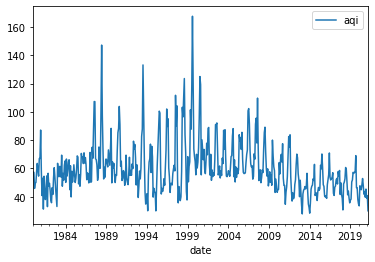

In [59]:
ts_df = df.dropna(subset=["date"]).set_index("date").resample("MS").agg({"aqi":"mean"})
ts_df.plot()

In [60]:
fb_df = ts_df.reset_index().rename(columns={"date":"ds", "aqi":"y"})
fb_df

,ds,y
0,1980-01-01,57.451613
1,1980-02-01,57.206897
2,1980-03-01,45.838710
3,1980-04-01,49.566667
4,1980-05-01,50.000000
...,...,...
490,2020-11-01,39.633333
491,2020-12-01,45.387097
492,2021-01-01,39.032258
493,2021-02-01,40.642857


In [61]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300, weekly_seasonality=False, daily_seasonality=False)
m.fit(fb_df, verbose=False)


Gradient evaluation took 0.000636 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.36 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000844 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000864 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000916 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.16 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of th

Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)


/Users/valerieschnapp/Envs/CSE_6242_Project-cP7jdTvd/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


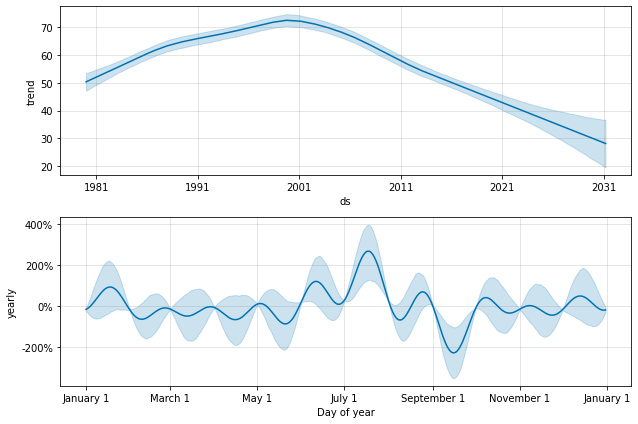

In [62]:
future = m.make_future_dataframe(periods=120, freq="MS")
fcst = m.predict(future)
fig = m.plot_components(fcst)

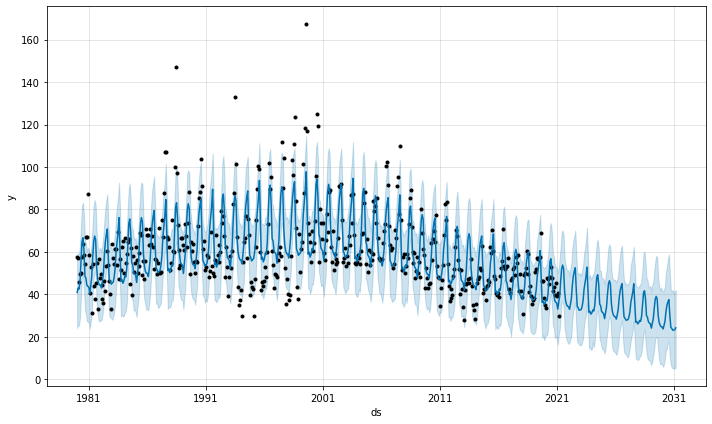

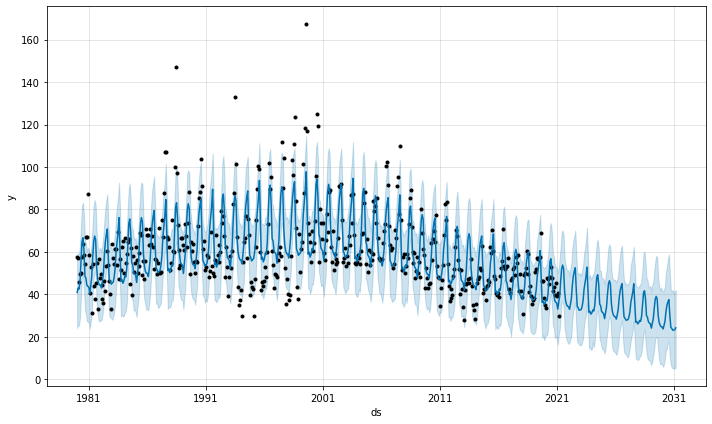

In [86]:
m.plot(fcst)

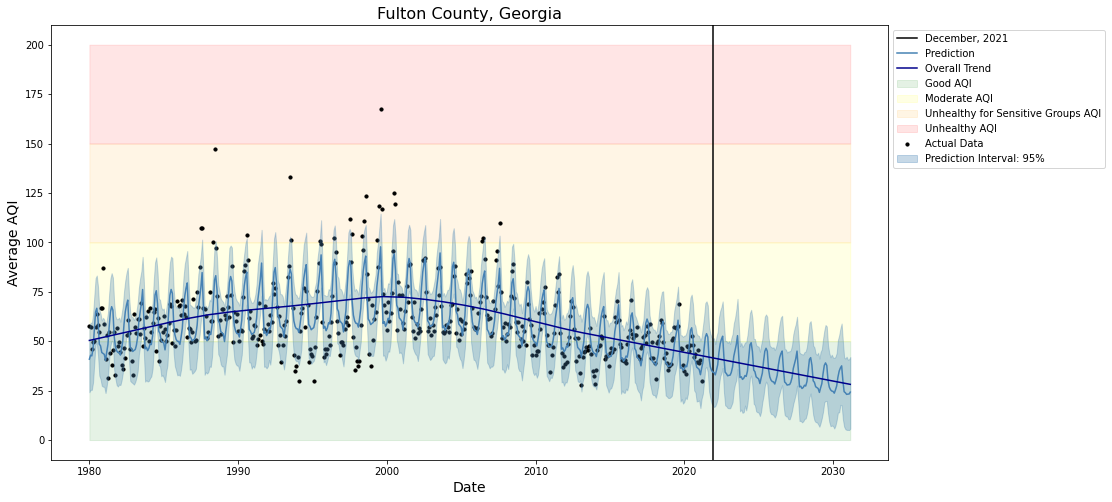

In [102]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.fill_between(x=fcst.ds, y1=0, y2=50, alpha=0.1, color="green", label="Good AQI")
ax.fill_between(x=fcst.ds, y1=50, y2=100, alpha=0.1, color="yellow", label="Moderate AQI")
ax.fill_between(x=fcst.ds, y1=100, y2=150, alpha=0.1, color="orange", label="Unhealthy for Sensitive Groups AQI")
ax.fill_between(x=fcst.ds, y1=150, y2=200, alpha=0.1, color="red", label="Unhealthy AQI")
plt.axvline(x=pd.to_datetime("2021-12-01"), c="k", label="December, 2021")
plt.scatter(fb_df.ds, fb_df.y, color="k", s=10, label="Actual Data")
plt.plot(fcst.ds, fcst.yhat, color="steelblue", label="Prediction")
ax.fill_between(x=fcst.ds, y1=fcst.yhat_lower, y2=fcst.yhat_upper, alpha=0.3, color="steelblue", label="Prediction Interval: 95%")
plt.plot(fcst.ds, fcst.trend, color="darkblue", label="Overall Trend")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Fulton County, Georgia", fontsize=16)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Average AQI", fontsize=14)
plt.show()

In [112]:
df.groupby(by="category").agg({"aqi":["min", "max"]}).sort_values(('aqi', 'min'))

aqi     
                                min  max
category                                
Good                              1   50
Moderate                         51  100
Unhealthy for Sensitive Groups  101  150
Unhealthy                       151  200
Very Unhealthy                  201  249